In [12]:
using NCDatasets
using Plots, ColorSchemes
using DataFrames, CSV
using SparseArrays, LinearAlgebra
using LaTeXStrings

In [90]:
#--------------------------------------------------------------------------------------
# Utility Functions
#--------------------------------------------------------------------------------------

function get_endpoints(ds, vars)

    out = Vector{Any}()

    for v in vars
        append!(out, [ds["$v"][:,:,end]])
    end

    return out[1], out[2], out[3], out[4], out[5]

end

function get_nonzero_axes(M)

    Cs = sparse(M)
    (II, JJ, _) = findnz(Cs) 
    
    return II, JJ

end 

function cut_off(ds, n)

    dss = copy(ds)
    co = 10^-6
    for i in range(1, n)
        dss[:, i] .= ifelse.(dss[:, i] .< co, co, dss[:, i])
    end

    return dss

end


function extinct(ds, n)

    dss = copy(ds)
    ex = 10^-6
    for i in range(1, n)
        dss[:, i] .= ifelse.(dss[:, i] .== ex, 0.0, dss[:, i])
    end

    return dss

end

function get_zc(ds, H=890)

    dz = 10
    zc = [dz/2:dz:(H-dz/2)]

    return zc
end

get_zc (generic function with 2 methods)

In [129]:
#--------------------------------------------------------------------------------------
# R* Phyto on Nutrients
#--------------------------------------------------------------------------------------

function get_rstar_P(P, Z, ds, np, season)
    
    mort_p = p_mortality(P, ds, np)
    grz_p = p_grazing(P, Z, ds, np)
    loss_p = p_loss(mort_p, grz_p, np)
    RstarP_i = RstarP(loss_p, ds, np, season)

    return RstarP_i, loss_p

end

function p_mortality(P, ds, np)

    m_lp = 1e-1
    m_qp = 1e-1
    mort_p = Any[]
    for i in range(1, np)
        push!(mort_p, (m_lp .+ m_qp .* P[:,i]))
    end

    return mort_p

end

function p_grazing(P, Z, ds, np)

    GrM = ds["GrM"][:]
    grazing = Any[]
    g_max = 1.0
    K_g = ds["K_g"][1]

    prey = GrM[1,1:np]' .*P[:,:]
    for i in range(1, np)
        gp_i = g_max .* prey[:,i] ./ (prey[:,i] .+ K_g)
        grz_i = (gp_i .* Z[:,1] .* GrM[1,i]') ./ prey[:,i]
        push!(grazing, grz_i)
    end

    return grazing

end

function p_loss(mortality, grazing, np)

    loss = Any[]
    for i in range(1, np)
        push!(loss, mortality[i] .+ grazing[i])
    end

    return loss
end

function RstarP(loss, ds, np, season)

    umax_ij = ds["umax_ij"][:]
    Kp_ij = ds["Kp_ij"][:]
    temp_mod = get_temp_mod(season)

    RS = Any[]
    for i =  range(1, np)
        push!(RS, Kp_ij[i] .* loss[i] ./ (umax_ij[i] .* temp_mod .- loss[i]))
    end

    for i in range(1, length(RS))
        RS[i] = check_for_negatives(RS[i])
    end

    return RS
end

function get_temp_mod(season)
    #fit to SPOT data (approx 20 to 4, approx 16 to 4)
    if season == "Win"
        temp_mod = CSV.read("/home/lee/Dropbox/Development/NPZBD_1D/data/temp_mod/win_temp_mod.csv", DataFrame)
    else
        temp_mod = CSV.read("/home/lee/Dropbox/Development/NPZBD_1D/data/temp_mod/sum_temp_mod.csv", DataFrame)
    end

    return Matrix(temp_mod)
end

function check_for_negatives(RS)

    for i in eachindex(RS)
        RS[i] = ifelse(RS[i] < 0, NaN, RS[i])
    end

    return RS

end

check_for_negatives (generic function with 1 method)

In [121]:
function plot_rstar_P(rstar_w, rstar_s, Pw, Ps, Nw, Ns, ds, np)

    H = 200
    dz = ds["dz"][:]
    zc = [dz/2:dz:(H-dz/2)]
    lg=:bottomright
    tfs=12

    if np == 1
        p1 = plot(rstar_w[1][1:20], -zc, lw=4, lc="olivedrab3", label="", ylabel="Depth (m)", xrotation=45, 
        xguidefontsize=12, xlabel=L"mmol/m^3", border=:box, legend=lg, xscale=:log10, title="Win", titlefontsize=tfs)
        plot!(Nw[1:20, 1], -zc, lw=3, lc="blue3", linestyle=:dot,label="", alpha=0.4)

        p2 = plot(rstar_s[1][1:20], -zc, lw=4, lc="olivedrab3", label=" P1", ylabel="Depth (m)", xrotation=45, 
        xguidefontsize=12, xlabel=L"mmol/m^3", border=:box, legend=lg, xscale=:log10, title="Sum", titlefontsize=tfs, yformatter=Returns(""))
        plot!(Ns[1:20, 1], -zc, lw=4, lc="blue3", linestyle=:dot,label=" N", alpha=0.4)
    
    elseif np == 2
        p1 = plot(rstar_w[1][1:20], -zc, lw=4, lc="olivedrab3", label="", ylabel="Depth (m)", xrotation=45, 
        xguidefontsize=12, xlabel="", border=:box, legend=lg, xscale=:log10, title="", titlefontsize=tfs)
        plot!(rstar_w[2][1:20], -zc, lw=4, lc="darkgreen",  label="")
        plot!(Nw[1:20, 1], -zc, lw=4, lc="blue3", linestyle=:dot, label=L" N", alpha=0.4, legend=:bottom)

        p2 = plot(Pw[1:20, 1], -zc, lw=4, lc="olivedrab3", label=L" P1", ylabel="", xrotation=45, 
        xguidefontsize=12, xlabel="", border=:box, legend=lg, title="", titlefontsize=tfs, yformatter=Returns(""), xlims=(-0.01, 0.6))
        plot!(Pw[1:20, 2], -zc, lw=4, lc="darkgreen",  label=L" P2")

        p3 = plot(rstar_s[1][1:20], -zc, lw=4, lc="olivedrab3", label="", ylabel="Depth (m)", xrotation=45, 
        xguidefontsize=12, xlabel=L"R*", border=:box, legend=lg, xscale=:log10, title="", titlefontsize=tfs)
        plot!(rstar_s[2][1:20], -zc, lw=4, lc="darkgreen",  label="")
        plot!(Ns[1:20, 1], -zc, lw=4, lc="blue3", linestyle=:dot,label=L" N", alpha=0.4, legend=:bottom)

        p4 = plot(Ps[1:20, 1], -zc, lw=4, lc="olivedrab3", label=L" P1", ylabel="", xrotation=45, 
        xguidefontsize=12, xlabel=L"Biomass", border=:box, legend=lg, title="", titlefontsize=tfs, yformatter=Returns(""), xlims=(-0.01, 0.6))
        plot!(Ps[1:20, 2], -zc, lw=4, lc="darkgreen",  label=L" P2")

    elseif np == 4
        p1 = plot(rstar_w[1][1:20], -zc, lw=4, lc="olivedrab3", label="", ylabel="Depth (m)", xrotation=45, 
        xguidefontsize=12, xlabel="", border=:box, legend=lg, xscale=:log10, title="", titlefontsize=tfs)
        plot!(rstar_w[2][1:20], -zc, lw=4, lc="darkgreen",  label="")
        plot!(rstar_w[3][1:20], -zc, lw=4, lc="red4",  label="")
        plot!(rstar_w[4][1:20], -zc, lw=4, lc="cyan4",  label="")
        plot!(Nw[1:20, 1], -zc, lw=4, lc="blue3", linestyle=:dot, label=L" N", alpha=0.4, legend=:bottom)

        p2 = plot(Pw[1:20, 1], -zc, lw=4, lc="olivedrab3", label=L" P1", ylabel="", xrotation=45, 
        xguidefontsize=12, xlabel="", border=:box, legend=lg, title="", titlefontsize=tfs, yformatter=Returns(""), xlims=(-0.01, 0.6))
        plot!(Pw[1:20, 2], -zc, lw=4, lc="darkgreen",  label=L" P2")
        plot!(Pw[1:20, 3], -zc, lw=4, lc="red4",  label=L" P3")
        plot!(Pw[1:20, 4], -zc, lw=4, lc="cyan4",  label=L" P4")

        p3 = plot(rstar_s[1][1:20], -zc, lw=4, lc="olivedrab3", label="", ylabel="Depth (m)", xrotation=45, 
        xguidefontsize=12, xlabel=L"R*", border=:box, legend=lg, xscale=:log10, title="", titlefontsize=tfs)
        plot!(rstar_s[2][1:20], -zc, lw=4, lc="darkgreen",  label="")
        plot!(rstar_s[3][1:20], -zc, lw=4, lc="red4",  label="")
        plot!(rstar_s[4][1:20], -zc, lw=4, lc="cyan4",  label="")
        plot!(Ns[1:20, 1], -zc, lw=4, lc="blue3", linestyle=:dot,label=L" N", alpha=0.4, legend=:bottom)

        p4 = plot(Ps[1:20, 1], -zc, lw=4, lc="olivedrab3", label=L" P1", ylabel="", xrotation=45, 
        xguidefontsize=12, xlabel=L"Biomass", border=:box, legend=lg, title="", titlefontsize=tfs, yformatter=Returns(""), xlims=(-0.01, 0.6))
        plot!(Ps[1:20, 2], -zc, lw=4, lc="darkgreen",  label=L" P2")
        plot!(Ps[1:20, 3], -zc, lw=4, lc="red4",  label=L" P3")
        plot!(Ps[1:20, 4], -zc, lw=4, lc="cyan4",  label=L" P4")
        
    else
    end
    
    combined = plot(p1, p2, p3, p4,
    fg_legend = :transparent,
    layout = (2,2),
    size=(450,600),
    plot_title=L"R* P_N"
    )

    savefig(combined,"/home/lee/Dropbox/Development/NPZBD_1D/notebooks/plots/rstarP_1N$(np)P.png")

    return combined

end

plot_rstar_P (generic function with 3 methods)

<h3> 1N 2P 2Z 2B 2D </h3>

<b> Umax_i </b>

* P1 = 1.091275617275966 (gleaner)
* P2 = 3.091275617275966 (opportunist)

* Each P competes for pool of N 

In [114]:
winter = NCDataset("/home/lee/Dropbox/Development/NPZBD_1D/results/outfiles/out_100y_20230905_2005.nc")
summer = NCDataset("/home/lee/Dropbox/Development/NPZBD_1D/results/outfiles/out_100y_20230905_2301.nc")
CMd = display(winter["CM"][:])
GrMd = display(winter["GrM"][:])

2×2 Matrix{Float64}:
 1.0  0.0
 0.0  1.0

2×4 Matrix{Float64}:
 1.0  1.0  0.0  0.0
 0.0  0.0  1.0  1.0

In [ ]:
# Get endpoints 
Nw, Pw, Zw, Bw, Dw = get_endpoints(winter, ["n", "p", "z", "b", "d"])
Ns, Ps, Zs, Bs, Ds = get_endpoints(summer, ["n", "p", "z", "b", "d"])

# Set all biomass values below cut-off (10^-6) equal to 0
Pww = cut_off(Pw, 2)
Pss = cut_off(Ps, 2)

# Calculate Rstar P
rstarP_w = get_rstar_P(Pww, Zw, winter, 2, "Win")
rstarP_s = get_rstar_P(Pss, Zs, summer, 2, "Sum")

# set low biomass to zero
Pwe = extinct(Pww, 2)
Pse = extinct(Pss, 2)

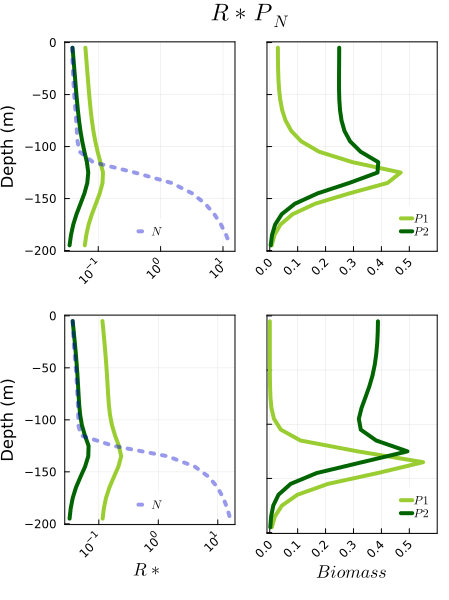

In [120]:
# Plot
plot_rstar_P(rstarP_w, rstarP_s, Pwe, Pse, Nw, Ns, winter,  2)

<h3> 1N 4P 3Z 7B 4D </h3>

Umax_i = [  2.091275617275966 ]

* Each B grazes its own D pool  - B1 grazes POM and B2 grazes DOM
* One Z grazes P, one POM consumer, one DOM consumer

In [130]:
winter = NCDataset("/home/lee/Dropbox/Development/NPZBD_1D/results/outfiles/out_100y_20230827_1345.nc")
summer = NCDataset("/home/lee/Dropbox/Development/NPZBD_1D/results/outfiles/out_100y_20230827_1710.nc")
CMd = display(winter["CM"][:])
GrMd = display(winter["GrM"][:])

4×7 Matrix{Float64}:
 1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  1.0
 0.0  0.0  1.0  0.0  0.0  1.0  0.0
 0.0  0.0  0.0  1.0  1.0  0.0  0.0

3×11 Matrix{Float64}:
 1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0

In [112]:
winter["umax_i"][:]

4-element Vector{Float64}:
 0.20554080759569854
 1.091275617275966
 2.5976524628164306
 4.598270878643895

In [131]:
# Get endpoints and set all biomass values below cut-off (10^-6) equal to cut-off
Nw, Pw, Zw, Bw, Dw = get_endpoints(winter, ["n", "p", "z", "b", "d"])
Ns, Ps, Zs, Bs, Ds = get_endpoints(summer, ["n", "p", "z", "b", "d"])

Pww = cut_off(Pw, 4)
Pss = cut_off(Ps, 4)

# Calculate Rstar P
rstarP_w, loss_w = get_rstar_P(Pww, Zw, winter, 4, "Win")
rstarP_s, loss_s = get_rstar_P(Pss, Zs, summer, 4, "Sum")

# set low biomass to zero
Pwe = extinct(Pww, 4)
Pse = extinct(Pss, 4)

89×4 Matrix{Float64}:
 0.125609  0.0  0.276795  0.0
 0.125927  0.0  0.276799  0.0
 0.127406  0.0  0.277499  0.0
 0.132093  0.0  0.28089   0.0
 0.143918  0.0  0.290682  0.0
 0.167529  0.0  0.309358  0.0
 0.199899  0.0  0.32586   0.0
 0.211905  0.0  0.297335  0.0
 0.181438  0.0  0.230676  0.0
 0.129733  0.0  0.154828  0.0
 ⋮                        
 0.0       0.0  0.0       0.0
 0.0       0.0  0.0       0.0
 0.0       0.0  0.0       0.0
 0.0       0.0  0.0       0.0
 0.0       0.0  0.0       0.0
 0.0       0.0  0.0       0.0
 0.0       0.0  0.0       0.0
 0.0       0.0  0.0       0.0
 0.0       0.0  0.0       0.0

In [133]:
loss_w[4]

89-element Vector{Float64}:
 0.22197296417291446
 0.22175104197557177
 0.22115642210612768
 0.21997519249578426
 0.2179192690138656
 0.21462453199613415
 0.2096699382960366
 0.2026376064140578
 0.1932411819121092
 0.18153432644830217
 ⋮
 0.10000011620359359
 0.10000011589399047
 0.10000011564958183
 0.10000011546042892
 0.10000011531800808
 0.10000011521500125
 0.10000011514512065
 0.10000011510296157
 0.10000011508387817

In [128]:
rstarP_w[4]

89×1 Matrix{Float64}:
   1.8040741393282915
   4.7101718099189025
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
  56.24617674078165
   1.6143000947619524
   ⋮
   0.33510928010773666
   0.33860075293415437
   0.34208070486861775
   0.3455486739478096
   0.34900419850962083
   0.3524468177064819
   0.3558760720187902
   0.3592915037668495
   0.3625650021952345

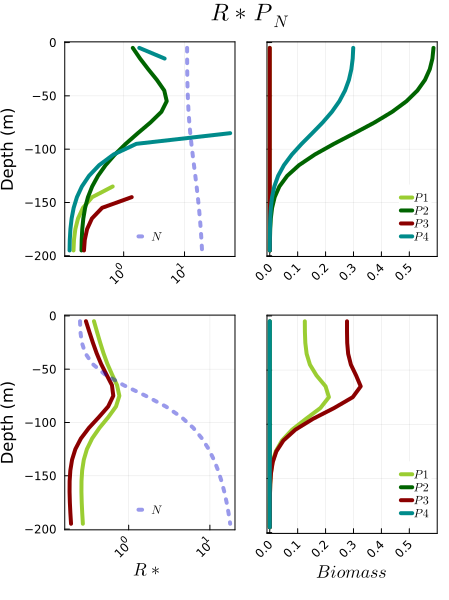

In [124]:
# Plot
plot_rstar_P(rstarP_w, rstarP_s, Pww, Pss, Nw, Ns, winter,  4)